In [1]:
# 基本套件
import os
import random
import numpy as np
from PIL import Image
from tqdm import tqdm

# PyTorch 套件
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# 評估指標
import math

# 視覺化
import matplotlib.pyplot as plt

# 驗證 GPU 狀態
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [6]:
## PromptIR: Prompting for All-in-One Blind Image Restoration
## Vaishnav Potlapalli, Syed Waqas Zamir, Salman Khan, and Fahad Shahbaz Khan
## https://arxiv.org/abs/2306.13090


import torch
# print(torch.__version__)
import torch.nn as nn
import torch.nn.functional as F
from pdb import set_trace as stx
import numbers

from einops import rearrange
from einops.layers.torch import Rearrange
import time


##########################################################################
## Layer Norm

def to_3d(x):
    return rearrange(x, 'b c h w -> b (h w) c')

def to_4d(x,h,w):
    return rearrange(x, 'b (h w) c -> b c h w',h=h,w=w)

class BiasFree_LayerNorm(nn.Module):
    def __init__(self, normalized_shape):
        super(BiasFree_LayerNorm, self).__init__()
        if isinstance(normalized_shape, numbers.Integral):
            normalized_shape = (normalized_shape,)
        normalized_shape = torch.Size(normalized_shape)

        assert len(normalized_shape) == 1

        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.normalized_shape = normalized_shape

    def forward(self, x):
        sigma = x.var(-1, keepdim=True, unbiased=False)
        return x / torch.sqrt(sigma+1e-5) * self.weight
    




class WithBias_LayerNorm(nn.Module):
    def __init__(self, normalized_shape):
        super(WithBias_LayerNorm, self).__init__()
        if isinstance(normalized_shape, numbers.Integral):
            normalized_shape = (normalized_shape,)
        normalized_shape = torch.Size(normalized_shape)

        assert len(normalized_shape) == 1

        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.normalized_shape = normalized_shape

    def forward(self, x):
        mu = x.mean(-1, keepdim=True)
        sigma = x.var(-1, keepdim=True, unbiased=False)
        return (x - mu) / torch.sqrt(sigma+1e-5) * self.weight + self.bias


class LayerNorm(nn.Module):
    def __init__(self, dim, LayerNorm_type):
        super(LayerNorm, self).__init__()
        if LayerNorm_type =='BiasFree':
            self.body = BiasFree_LayerNorm(dim)
        else:
            self.body = WithBias_LayerNorm(dim)

    def forward(self, x):
        h, w = x.shape[-2:]
        return to_4d(self.body(to_3d(x)), h, w)



##########################################################################
## Gated-Dconv Feed-Forward Network (GDFN)
class FeedForward(nn.Module):
    def __init__(self, dim, ffn_expansion_factor, bias):
        super(FeedForward, self).__init__()

        hidden_features = int(dim*ffn_expansion_factor)

        self.project_in = nn.Conv2d(dim, hidden_features*2, kernel_size=1, bias=bias)

        self.dwconv = nn.Conv2d(hidden_features*2, hidden_features*2, kernel_size=3, stride=1, padding=1, groups=hidden_features*2, bias=bias)

        self.project_out = nn.Conv2d(hidden_features, dim, kernel_size=1, bias=bias)

    def forward(self, x):
        x = self.project_in(x)
        x1, x2 = self.dwconv(x).chunk(2, dim=1)
        x = F.gelu(x1) * x2
        x = self.project_out(x)
        return x



##########################################################################
## Multi-DConv Head Transposed Self-Attention (MDTA)
class Attention(nn.Module):
    def __init__(self, dim, num_heads, bias):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        self.temperature = nn.Parameter(torch.ones(num_heads, 1, 1))

        self.qkv = nn.Conv2d(dim, dim*3, kernel_size=1, bias=bias)
        self.qkv_dwconv = nn.Conv2d(dim*3, dim*3, kernel_size=3, stride=1, padding=1, groups=dim*3, bias=bias)
        self.project_out = nn.Conv2d(dim, dim, kernel_size=1, bias=bias)
        


    def forward(self, x):
        b,c,h,w = x.shape

        qkv = self.qkv_dwconv(self.qkv(x))
        q,k,v = qkv.chunk(3, dim=1)   
        
        q = rearrange(q, 'b (head c) h w -> b head c (h w)', head=self.num_heads)
        k = rearrange(k, 'b (head c) h w -> b head c (h w)', head=self.num_heads)
        v = rearrange(v, 'b (head c) h w -> b head c (h w)', head=self.num_heads)

        q = torch.nn.functional.normalize(q, dim=-1)
        k = torch.nn.functional.normalize(k, dim=-1)

        attn = (q @ k.transpose(-2, -1)) * self.temperature
        attn = attn.softmax(dim=-1)

        out = (attn @ v)
        
        out = rearrange(out, 'b head c (h w) -> b (head c) h w', head=self.num_heads, h=h, w=w)

        out = self.project_out(out)
        return out



class resblock(nn.Module):
    def __init__(self, dim):

        super(resblock, self).__init__()
        # self.norm = LayerNorm(dim, LayerNorm_type='BiasFree')

        self.body = nn.Sequential(nn.Conv2d(dim, dim, kernel_size=3, stride=1, padding=1, bias=False),
                                  nn.PReLU(),
                                  nn.Conv2d(dim, dim, kernel_size=3, stride=1, padding=1, bias=False))

    def forward(self, x):
        res = self.body((x))
        res += x
        return res


##########################################################################
## Resizing modules
class Downsample(nn.Module):
    def __init__(self, n_feat):
        super(Downsample, self).__init__()

        self.body = nn.Sequential(nn.Conv2d(n_feat, n_feat//2, kernel_size=3, stride=1, padding=1, bias=False),
                                  nn.PixelUnshuffle(2))

    def forward(self, x):
        return self.body(x)

class Upsample(nn.Module):
    def __init__(self, n_feat):
        super(Upsample, self).__init__()

        self.body = nn.Sequential(nn.Conv2d(n_feat, n_feat*2, kernel_size=3, stride=1, padding=1, bias=False),
                                  nn.PixelShuffle(2))

    def forward(self, x):
        return self.body(x)


##########################################################################
## Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, ffn_expansion_factor, bias, LayerNorm_type):
        super(TransformerBlock, self).__init__()

        self.norm1 = LayerNorm(dim, LayerNorm_type)
        self.attn = Attention(dim, num_heads, bias)
        self.norm2 = LayerNorm(dim, LayerNorm_type)
        self.ffn = FeedForward(dim, ffn_expansion_factor, bias)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.ffn(self.norm2(x))

        return x



##########################################################################
## Overlapped image patch embedding with 3x3 Conv
class OverlapPatchEmbed(nn.Module):
    def __init__(self, in_c=3, embed_dim=48, bias=False):
        super(OverlapPatchEmbed, self).__init__()

        self.proj = nn.Conv2d(in_c, embed_dim, kernel_size=3, stride=1, padding=1, bias=bias)

    def forward(self, x):
        x = self.proj(x)

        return x




##########################################################################
##---------- Prompt Gen Module -----------------------
class PromptGenBlock(nn.Module):
    def __init__(self,prompt_dim=128,prompt_len=5,prompt_size = 96,lin_dim = 192):
        super(PromptGenBlock,self).__init__()
        self.prompt_param = nn.Parameter(torch.rand(1,prompt_len,prompt_dim,prompt_size,prompt_size))
        self.linear_layer = nn.Linear(lin_dim,prompt_len)
        self.conv3x3 = nn.Conv2d(prompt_dim,prompt_dim,kernel_size=3,stride=1,padding=1,bias=False)
        

    def forward(self,x):
        B,C,H,W = x.shape
        emb = x.mean(dim=(-2,-1))
        prompt_weights = F.softmax(self.linear_layer(emb),dim=1)
        prompt = prompt_weights.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1) * self.prompt_param.unsqueeze(0).repeat(B,1,1,1,1,1).squeeze(1)
        prompt = torch.sum(prompt,dim=1)
        prompt = F.interpolate(prompt,(H,W),mode="bilinear")
        prompt = self.conv3x3(prompt)

        return prompt





##########################################################################
##---------- PromptIR -----------------------

class PromptIR(nn.Module):
    def __init__(self, 
        inp_channels=3, 
        out_channels=3, 
        dim = 48,
        num_blocks = [4,6,6,8], 
        num_refinement_blocks = 4,
        heads = [1,2,4,8],
        ffn_expansion_factor = 2.66,
        bias = False,
        LayerNorm_type = 'WithBias',   ## Other option 'BiasFree'
        decoder = True,
    ):

        super(PromptIR, self).__init__()

        self.patch_embed = OverlapPatchEmbed(inp_channels, dim)
        
        
        self.decoder = decoder
        
        if self.decoder:
            self.prompt1 = PromptGenBlock(prompt_dim=64,prompt_len=5,prompt_size = 64,lin_dim = 96)
            self.prompt2 = PromptGenBlock(prompt_dim=128,prompt_len=5,prompt_size = 32,lin_dim = 192)
            self.prompt3 = PromptGenBlock(prompt_dim=320,prompt_len=5,prompt_size = 16,lin_dim = 384)
        
        
        self.chnl_reduce1 = nn.Conv2d(64,64,kernel_size=1,bias=bias)
        self.chnl_reduce2 = nn.Conv2d(128,128,kernel_size=1,bias=bias)
        self.chnl_reduce3 = nn.Conv2d(320,256,kernel_size=1,bias=bias)



        self.reduce_noise_channel_1 = nn.Conv2d(dim + 64,dim,kernel_size=1,bias=bias)
        self.encoder_level1 = nn.Sequential(*[TransformerBlock(dim=dim, num_heads=heads[0], ffn_expansion_factor=ffn_expansion_factor, bias=bias, LayerNorm_type=LayerNorm_type) for i in range(num_blocks[0])])
        
        self.down1_2 = Downsample(dim) ## From Level 1 to Level 2

        self.reduce_noise_channel_2 = nn.Conv2d(int(dim*2**1) + 128,int(dim*2**1),kernel_size=1,bias=bias)
        self.encoder_level2 = nn.Sequential(*[TransformerBlock(dim=int(dim*2**1), num_heads=heads[1], ffn_expansion_factor=ffn_expansion_factor, bias=bias, LayerNorm_type=LayerNorm_type) for i in range(num_blocks[1])])
        
        self.down2_3 = Downsample(int(dim*2**1)) ## From Level 2 to Level 3

        self.reduce_noise_channel_3 = nn.Conv2d(int(dim*2**2) + 256,int(dim*2**2),kernel_size=1,bias=bias)
        self.encoder_level3 = nn.Sequential(*[TransformerBlock(dim=int(dim*2**2), num_heads=heads[2], ffn_expansion_factor=ffn_expansion_factor, bias=bias, LayerNorm_type=LayerNorm_type) for i in range(num_blocks[2])])

        self.down3_4 = Downsample(int(dim*2**2)) ## From Level 3 to Level 4
        self.latent = nn.Sequential(*[TransformerBlock(dim=int(dim*2**3), num_heads=heads[3], ffn_expansion_factor=ffn_expansion_factor, bias=bias, LayerNorm_type=LayerNorm_type) for i in range(num_blocks[3])])

        self.up4_3 = Upsample(int(dim*2**2)) ## From Level 4 to Level 3
        self.reduce_chan_level3 = nn.Conv2d(int(dim*2**1)+192, int(dim*2**2), kernel_size=1, bias=bias)
        self.noise_level3 = TransformerBlock(dim=int(dim*2**2) + 512, num_heads=heads[2], ffn_expansion_factor=ffn_expansion_factor, bias=bias, LayerNorm_type=LayerNorm_type)
        self.reduce_noise_level3 = nn.Conv2d(int(dim*2**2)+512,int(dim*2**2),kernel_size=1,bias=bias)


        self.decoder_level3 = nn.Sequential(*[TransformerBlock(dim=int(dim*2**2), num_heads=heads[2], ffn_expansion_factor=ffn_expansion_factor, bias=bias, LayerNorm_type=LayerNorm_type) for i in range(num_blocks[2])])


        self.up3_2 = Upsample(int(dim*2**2)) ## From Level 3 to Level 2
        self.reduce_chan_level2 = nn.Conv2d(int(dim*2**2), int(dim*2**1), kernel_size=1, bias=bias)
        self.noise_level2 = TransformerBlock(dim=int(dim*2**1) + 224, num_heads=heads[2], ffn_expansion_factor=ffn_expansion_factor, bias=bias, LayerNorm_type=LayerNorm_type)
        self.reduce_noise_level2 = nn.Conv2d(int(dim*2**1)+224,int(dim*2**2),kernel_size=1,bias=bias)


        self.decoder_level2 = nn.Sequential(*[TransformerBlock(dim=int(dim*2**1), num_heads=heads[1], ffn_expansion_factor=ffn_expansion_factor, bias=bias, LayerNorm_type=LayerNorm_type) for i in range(num_blocks[1])])
        
        self.up2_1 = Upsample(int(dim*2**1))  ## From Level 2 to Level 1  (NO 1x1 conv to reduce channels)

        self.noise_level1 = TransformerBlock(dim=int(dim*2**1)+64, num_heads=heads[2], ffn_expansion_factor=ffn_expansion_factor, bias=bias, LayerNorm_type=LayerNorm_type)
        self.reduce_noise_level1 = nn.Conv2d(int(dim*2**1)+64,int(dim*2**1),kernel_size=1,bias=bias)


        self.decoder_level1 = nn.Sequential(*[TransformerBlock(dim=int(dim*2**1), num_heads=heads[0], ffn_expansion_factor=ffn_expansion_factor, bias=bias, LayerNorm_type=LayerNorm_type) for i in range(num_blocks[0])])
        
        self.refinement = nn.Sequential(*[TransformerBlock(dim=int(dim*2**1), num_heads=heads[0], ffn_expansion_factor=ffn_expansion_factor, bias=bias, LayerNorm_type=LayerNorm_type) for i in range(num_refinement_blocks)])
                    
        self.output = nn.Conv2d(int(dim*2**1), out_channels, kernel_size=3, stride=1, padding=1, bias=bias)

    def forward(self, inp_img,noise_emb = None):

        inp_enc_level1 = self.patch_embed(inp_img)

        out_enc_level1 = self.encoder_level1(inp_enc_level1)
        
        inp_enc_level2 = self.down1_2(out_enc_level1)

        out_enc_level2 = self.encoder_level2(inp_enc_level2)

        inp_enc_level3 = self.down2_3(out_enc_level2)

        out_enc_level3 = self.encoder_level3(inp_enc_level3)
        
        inp_enc_level4 = self.down3_4(out_enc_level3)        
        latent = self.latent(inp_enc_level4)

        if self.decoder:
            dec3_param = self.prompt3(latent)

            latent = torch.cat([latent, dec3_param], 1)
            latent = self.noise_level3(latent)
            latent = self.reduce_noise_level3(latent)
            
        inp_dec_level3 = self.up4_3(latent)

        inp_dec_level3 = torch.cat([inp_dec_level3, out_enc_level3], 1)
        inp_dec_level3 = self.reduce_chan_level3(inp_dec_level3)

        out_dec_level3 = self.decoder_level3(inp_dec_level3)
        
        if self.decoder:
            dec2_param = self.prompt2(out_dec_level3)
            out_dec_level3 = torch.cat([out_dec_level3, dec2_param], 1)
            out_dec_level3 = self.noise_level2(out_dec_level3)
            out_dec_level3 = self.reduce_noise_level2(out_dec_level3)

        inp_dec_level2 = self.up3_2(out_dec_level3)
        inp_dec_level2 = torch.cat([inp_dec_level2, out_enc_level2], 1)
        inp_dec_level2 = self.reduce_chan_level2(inp_dec_level2)

        out_dec_level2 = self.decoder_level2(inp_dec_level2)
        if self.decoder:
           
            dec1_param = self.prompt1(out_dec_level2)
            out_dec_level2 = torch.cat([out_dec_level2, dec1_param], 1)
            out_dec_level2 = self.noise_level1(out_dec_level2)
            out_dec_level2 = self.reduce_noise_level1(out_dec_level2)
        
        inp_dec_level1 = self.up2_1(out_dec_level2)
        inp_dec_level1 = torch.cat([inp_dec_level1, out_enc_level1], 1)
        
        out_dec_level1 = self.decoder_level1(inp_dec_level1)

        out_dec_level1 = self.refinement(out_dec_level1)


        out_dec_level1 = self.output(out_dec_level1) + inp_img


        return out_dec_level1

In [7]:
import torchvision.transforms.functional as TF
import random

class PairedTransform:
    def __init__(self, crop_size=(128, 128)):
        self.crop_size = crop_size

    def __call__(self, degraded, clean):
        # 隨機水平翻轉
        if random.random() > 0.5:
            degraded = TF.hflip(degraded)
            clean = TF.hflip(clean)

        # 隨機垂直翻轉
        if random.random() > 0.5:
            degraded = TF.vflip(degraded)
            clean = TF.vflip(clean)

        # 隨機裁切
        i, j, h, w = transforms.RandomCrop.get_params(degraded, output_size=self.crop_size)
        degraded = TF.crop(degraded, i, j, h, w)
        clean = TF.crop(clean, i, j, h, w)

        # 轉為 tensor
        degraded = TF.to_tensor(degraded)
        clean = TF.to_tensor(clean)

        return degraded, clean

class RestorationDataset(Dataset):
    def __init__(self, degraded_dir, clean_dir, transform=None):
        self.degraded_dir = degraded_dir
        self.clean_dir = clean_dir
        self.transform = transform

        self.pairs = []
        for filename in os.listdir(degraded_dir):
            if not filename.endswith(".png"):
                continue
            degraded_path = os.path.join(degraded_dir, filename)

            if filename.startswith("rain"):
                clean_name = filename.replace("rain-", "rain_clean-")
            elif filename.startswith("snow"):
                clean_name = filename.replace("snow-", "snow_clean-")
            else:
                continue

            clean_path = os.path.join(clean_dir, clean_name)
            if os.path.exists(clean_path):
                self.pairs.append((degraded_path, clean_path))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        degraded_path, clean_path = self.pairs[idx]
        degraded_img = Image.open(degraded_path).convert("RGB")
        clean_img = Image.open(clean_path).convert("RGB")

        if self.transform:
            degraded_img, clean_img = self.transform(degraded_img, clean_img)

        return {
            "degraded": degraded_img,
            "clean": clean_img
        }

paired_transform = PairedTransform(crop_size=(128, 128))

train_dataset = RestorationDataset(
    degraded_dir="/kaggle/input/dataset-all/hw4_realse_dataset/hw4_realse_dataset/train/degraded",
    clean_dir="/kaggle/input/dataset-all/hw4_realse_dataset/hw4_realse_dataset/train/clean",
    transform=paired_transform
)

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
import math

# ✅ PSNR function
def psnr(pred, target, max_pixel=1.0):
    mse = nn.functional.mse_loss(pred, target)
    return 20 * torch.log10(max_pixel / torch.sqrt(mse + 1e-8))

# ✅ 訓練函式
def train_model(model, train_loader, val_loader=None, num_epochs=40,lr=1e-4, save_path="best_model.pth"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.L1Loss()

    best_val_psnr = -float("inf")

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        total_psnr = 0.0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            degraded = batch["degraded"].to(device)
            clean = batch["clean"].to(device)
            #prompt_type = batch["prompt_type"].to(device)
            optimizer.zero_grad()
            output = model(degraded)
            loss = loss_fn(output, clean)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_psnr += psnr(output.detach(), clean).item()

        avg_loss = total_loss / len(train_loader)
        avg_psnr = total_psnr / len(train_loader)
        print(f"[Epoch {epoch+1}] Loss: {avg_loss:.4f}, PSNR: {avg_psnr:.2f}")

        # Optional: validation loop
        if val_loader is not None:
            model.eval()
            val_psnr = 0.0
            with torch.no_grad():
                for batch in val_loader:
                    degraded = batch["degraded"].to(device)
                    clean = batch["clean"].to(device)
                    prompt_type = batch["prompt_type"].to(device)

                    output = model(degraded)
                    val_psnr += psnr(output, clean).item()
            val_psnr /= len(val_loader)
            print(f"Validation PSNR: {val_psnr:.2f}")

            if val_psnr > best_val_psnr:
                best_val_psnr = val_psnr
                torch.save(model.state_dict(), save_path)
                print(f"✅ Model saved at epoch {epoch+1} with PSNR: {val_psnr:.2f}")

        else:
            # Save every 5 epochs (or always if no validation set)
            if (epoch + 1) % 5 == 0:
                torch.save(model.state_dict(), f"checkpoint_epoch{epoch+1}.pth")

    print("✅ Training Finished")

In [6]:

model = PromptIR() 

# 載入訓練好的權重
#checkpoint = torch.load("/kaggle/input/ver4_40/pytorch/default/1/checkpoint_epoch40.pth", map_location=device)
#print(checkpoint.keys())
#model.load_state_dict(checkpoint)

# 將模型搬到 GPU 並設為 eval 模式
model = model.to(device)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=1)

# 若有 val_dataset 可提供 val_loader，否則設 val_loader=None
train_model(model, train_loader, val_loader=None, num_epochs=40, lr=1e-4)


Epoch 1/40:   3%|▎         | 25/800 [00:28<14:33,  1.13s/it]


KeyboardInterrupt: 

In [9]:

model.eval()

PromptIR(
  (patch_embed): OverlapPatchEmbed(
    (proj): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (prompt1): PromptGenBlock(
    (linear_layer): Linear(in_features=96, out_features=5, bias=True)
    (conv3x3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (prompt2): PromptGenBlock(
    (linear_layer): Linear(in_features=192, out_features=5, bias=True)
    (conv3x3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (prompt3): PromptGenBlock(
    (linear_layer): Linear(in_features=384, out_features=5, bias=True)
    (conv3x3): Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (chnl_reduce1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (chnl_reduce2): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (chnl_reduce3): Conv2d(320, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (reduce_noise_channel

In [10]:
class TestImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = sorted([
            f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        fname = self.image_files[idx]
        img_path = os.path.join(self.image_dir, fname)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, fname

# --------- 2. Transform + DataLoader ---------
transform = transforms.Compose([
    transforms.ToTensor()  # Converts to (C, H, W) with [0, 1] float32
])

test_dir = "/kaggle/input/dataset-all/hw4_realse_dataset/hw4_realse_dataset/test/degraded"
test_dataset = TestImageDataset(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
import torch
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch.nn.functional as F

output_folder = "/kaggle/working/predicted_images"
npz_output_path = "pred.npz"
os.makedirs(output_folder, exist_ok=True)
with torch.no_grad():
    for i, (degraded, image_name) in enumerate(tqdm(test_loader)):
        degraded = degraded.to(device)


        output = model(degraded)
        output = torch.clamp(output, 0, 1)

        for b in range(output.shape[0]):
            img = (output[b].cpu().numpy() * 255).astype(np.uint8)
            img = np.transpose(img, (1, 2, 0))  # → (H, W, 3)
            img_pil = Image.fromarray(img)
            save_name = image_name[b] if isinstance(image_name[b], str) else f"{i*output.shape[0]+b}.png"
            img_pil.save(os.path.join(output_folder, save_name))

            
print(f"[INFO] 推論圖片已儲存到 {output_folder}")

# ==== 轉換為 pred.npz ====
images_dict = {}
image_filenames = sorted([
    f for f in os.listdir(output_folder)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
], key=lambda x: int(os.path.splitext(x)[0]))  # 確保排序正確

for filename in image_filenames:
    path = os.path.join(output_folder, filename)
    try:
        image = Image.open(path).convert('RGB')
        img_array = np.array(image, dtype=np.uint8)
        img_array = np.transpose(img_array, (2, 0, 1))  # (H, W, 3) → (3, H, W)
        images_dict[filename] = img_array
    except Exception as e:
        print(f"[ERROR] Failed to process {filename}: {e}")

np.savez(npz_output_path, **images_dict)
print(f"[SUCCESS] Saved {len(images_dict)} images to {npz_output_path}")

In [11]:
import torch
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch.nn.functional as F

output_folder = "/kaggle/working/predicted_images"
npz_output_path = "pred.npz"
os.makedirs(output_folder, exist_ok=True)

def split_into_patches(image_tensor, patch_size=128):
    """將 (B, C, H, W) 張量切成 (B*4, C, 128, 128)"""
    B, C, H, W = image_tensor.shape
    assert H == 256 and W == 256, "Input image must be 256x256"
    patches = []
    for i in range(2):
        for j in range(2):
            patch = image_tensor[:, :, i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
            patches.append(patch)
    return torch.cat(patches, dim=0)  # (B*4, C, 128, 128)

def merge_patches(patches, patch_size=128):
    """將 (B*4, C, 128, 128) 拼回 (B, C, 256, 256)"""
    B4, C, _, _ = patches.shape
    B = B4 // 4
    result = torch.zeros((B, C, patch_size * 2, patch_size * 2), device=patches.device)
    idx = 0
    for i in range(2):
        for j in range(2):
            result[:, :, i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = patches[idx*B:(idx+1)*B]
            idx += 1
    return result

with torch.no_grad():
    for i, (degraded, image_name) in enumerate(tqdm(test_loader)):
        degraded = degraded.to(device)

        # 切成4塊128x128
        patches = split_into_patches(degraded)

        # 逐塊跑模型
        outputs = model(patches)
        outputs = torch.clamp(outputs, 0, 1)

        # 拼回去
        merged_output = merge_patches(outputs)

        for b in range(merged_output.shape[0]):
            img = (merged_output[b].cpu().numpy() * 255).astype(np.uint8)
            img = np.transpose(img, (1, 2, 0))  # → (H, W, 3)
            img_pil = Image.fromarray(img)
            save_name = image_name[b] if isinstance(image_name[b], str) else f"{i*merged_output.shape[0]+b}.png"
            img_pil.save(os.path.join(output_folder, save_name))

print(f"[INFO] 推論圖片已儲存到 {output_folder}")

# ==== 轉換為 pred.npz ====
images_dict = {}
image_filenames = sorted([
    f for f in os.listdir(output_folder)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
], key=lambda x: int(os.path.splitext(x)[0]))  # 確保排序正確

for filename in image_filenames:
    path = os.path.join(output_folder, filename)
    try:
        image = Image.open(path).convert('RGB')
        img_array = np.array(image, dtype=np.uint8)
        img_array = np.transpose(img_array, (2, 0, 1))  # (H, W, 3) → (3, H, W)
        images_dict[filename] = img_array
    except Exception as e:
        print(f"[ERROR] Failed to process {filename}: {e}")

np.savez(npz_output_path, **images_dict)
print(f"[SUCCESS] Saved {len(images_dict)} images to {npz_output_path}")

100%|██████████| 100/100 [00:28<00:00,  3.53it/s]


[INFO] 推論圖片已儲存到 /kaggle/working/predicted_images
[SUCCESS] Saved 100 images to pred.npz


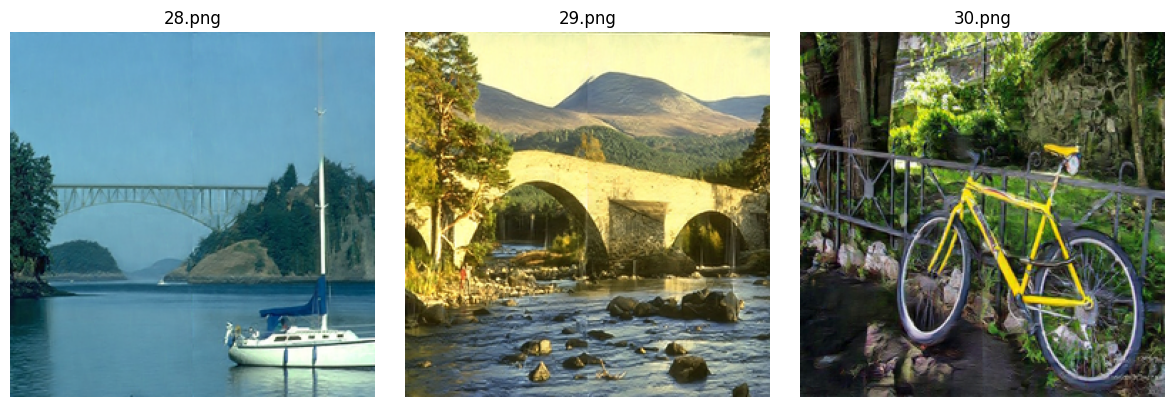

In [12]:
import matplotlib.pyplot as plt

# 隨機挑選幾張圖片來顯示
sample_filenames = list(images_dict.keys())[28:31]  # 顯示前3張，你也可以改成隨機選
plt.figure(figsize=(12, 4))

for i, fname in enumerate(sample_filenames):
    img = images_dict[fname]            # shape: (3, H, W)
    img = np.transpose(img, (1, 2, 0))  # shape: (H, W, 3)

    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.title(fname)
    plt.axis('off')

plt.tight_layout()
plt.show()